In [751]:
import pandas as pd
import numpy as np
import regex as re

import joblib
from tqdm import tqdm
import time


import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import skew

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, GridSearchCV, ParameterGrid, train_test_split

# we need this for classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor , RandomForestClassifier, BaggingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

from imblearn.pipeline import Pipeline



In [752]:
df = pd.read_csv("csv_files/healthcare-dataset-stroke-data.csv")

In [753]:
df.columns = df.columns.str.lower()

In [754]:
#drop the only "other" in gender column
df = df[df['gender'] != 'Other']


In [755]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [756]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   gender             5109 non-null   object 
 2   age                5109 non-null   float64
 3   hypertension       5109 non-null   int64  
 4   heart_disease      5109 non-null   int64  
 5   ever_married       5109 non-null   object 
 6   work_type          5109 non-null   object 
 7   residence_type     5109 non-null   object 
 8   avg_glucose_level  5109 non-null   float64
 9   bmi                4908 non-null   float64
 10  smoking_status     5109 non-null   object 
 11  stroke             5109 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 518.9+ KB


## Non Ordinal ML


### Rows to Numeric - For Non Ordinal ML

In [757]:
dfv1 = df.copy()

In [758]:
dfv1

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [759]:
dfv1['gender'].unique()


array(['Male', 'Female'], dtype=object)

In [760]:
dfv1['work_type'].unique()


array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [761]:
dfv1['residence_type'].unique()


array(['Urban', 'Rural'], dtype=object)

In [762]:
dfv1['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [763]:
"""
Gender collumn :
    Male = 1
    Female = 0

Age Collumn:
    Its fine

Hypertension:
    Its fine

Heart Disease:
    Its fine

ever_married:
    Yes = 1
    No = 0

work_type:
    Private = 1
    Self-employed = 1
    Govt_job = 1
    children = 1
    Never_worked = 1

residence_type:
    Urban = 1
    Rural = 0

avg_glucose_level:
    Its fine

bmi:
    delete missing values

smoking_status:
    never smoked = 1
    formerly smoked = 1
    smokes = 1
    Unknown = 1

"""
    
    

'\nGender collumn :\n    Male = 1\n    Female = 0\n\nAge Collumn:\n    Its fine\n\nHypertension:\n    Its fine\n\nHeart Disease:\n    Its fine\n\never_married:\n    Yes = 1\n    No = 0\n\nwork_type:\n    Private = 1\n    Self-employed = 1\n    Govt_job = 1\n    children = 1\n    Never_worked = 1\n\nresidence_type:\n    Urban = 1\n    Rural = 0\n\navg_glucose_level:\n    Its fine\n\nbmi:\n    delete missing values\n\nsmoking_status:\n    never smoked = 1\n    formerly smoked = 1\n    smokes = 1\n    Unknown = 1\n\n'

In [764]:
dfv1.dropna(subset=['bmi'], inplace=True)

In [765]:
# convert gender to numeric

In [766]:
dfv1['gender_numeric'] = df['gender'].map({'Male': 1, 'Female': 0})


In [767]:
dfv1.drop(columns=['gender'], inplace=True)

In [768]:
dfv1['ever_married_numeric'] = df['ever_married'].map({'Yes': 1, 'No': 0})

In [769]:
dfv1.drop(columns=['ever_married'], inplace=True)

In [770]:
dfv1['work_type'].unique()


array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [771]:
dfv1['work_type_private'] = (dfv1['work_type'].str.lower() == 'private').astype(int)
dfv1['work_type_self_employed'] = (dfv1['work_type'].str.lower() == 'self-employed').astype(int)
dfv1['work_type_govt_job'] = (dfv1['work_type'].str.lower() == 'govt_job').astype(int)
dfv1['work_type_children'] = (dfv1['work_type'].str.lower() == 'children').astype(int)
dfv1['work_type_never_worked'] = (dfv1['work_type'].str.lower() == 'never_worked').astype(int)

In [772]:
dfv1.drop(columns=['work_type'], inplace=True)

In [773]:
dfv1['residence_type_numeric'] = df['residence_type'].map({'Rural': 0, 'Urban': 1})

In [774]:
dfv1.drop(columns=['residence_type'], inplace=True)

In [775]:
dfv1['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [776]:
dfv1['smoke_status_formerly_smoked'] = (dfv1['smoking_status'].str.lower() == 'formerly smoked').astype(int)
dfv1['smoke_status_never_smoked'] = (dfv1['smoking_status'].str.lower() == 'never smoked').astype(int)
dfv1['smoke_status_smokes'] = (dfv1['smoking_status'].str.lower() == 'smokes').astype(int)
dfv1['smoke_status_unknown'] = (dfv1['smoking_status'].str.lower() == 'unknown').astype(int)

In [777]:
dfv1.drop(columns=['smoking_status'], inplace=True)

In [778]:
dfv1.drop(columns=['id'], inplace=True)

### KNN Classifier

In [779]:
dfv1.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_numeric', 'ever_married_numeric', 'work_type_private',
       'work_type_self_employed', 'work_type_govt_job', 'work_type_children',
       'work_type_never_worked', 'residence_type_numeric',
       'smoke_status_formerly_smoked', 'smoke_status_never_smoked',
       'smoke_status_smokes', 'smoke_status_unknown'],
      dtype='object')

In [780]:
dfv1

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_numeric,ever_married_numeric,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_numeric,smoke_status_formerly_smoked,smoke_status_never_smoked,smoke_status_smokes,smoke_status_unknown
0,67.0,0,1,228.69,36.6,1,1,1,1,0,0,0,0,1,1,0,0,0
2,80.0,0,1,105.92,32.5,1,1,1,1,0,0,0,0,0,0,1,0,0
3,49.0,0,0,171.23,34.4,1,0,1,1,0,0,0,0,1,0,0,1,0
4,79.0,1,0,174.12,24.0,1,0,1,0,1,0,0,0,0,0,1,0,0
5,81.0,0,0,186.21,29.0,1,1,1,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,13.0,0,0,103.08,18.6,0,0,0,0,0,0,1,0,0,0,0,0,1
5106,81.0,0,0,125.20,40.0,0,0,1,0,1,0,0,0,1,0,1,0,0
5107,35.0,0,0,82.99,30.6,0,0,1,0,1,0,0,0,0,0,1,0,0
5108,51.0,0,0,166.29,25.6,0,1,1,1,0,0,0,0,0,1,0,0,0


In [781]:
features = dfv1.drop(columns = ["stroke"])
target = dfv1["stroke"]

In [782]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(features, target, test_size = 0.20, random_state=0)

In [783]:
normalizer = StandardScaler()

In [784]:
normalizer.fit(X_train_knn)

StandardScaler()

In [785]:
X_train_norm_knn = normalizer.transform(X_train_knn)

X_test_norm_knn = normalizer.transform(X_test_knn)

In [786]:
X_train_norm_knn = pd.DataFrame(X_train_norm_knn, columns = X_train_knn.columns)
X_test_norm_knn = pd.DataFrame(X_test_norm_knn, columns = X_test_knn.columns)

In [787]:
knn = KNeighborsClassifier(n_neighbors=4)

In [788]:
knn.fit(X_train_norm_knn, y_train_knn)

KNeighborsClassifier(n_neighbors=4)

In [789]:
knn.score(X_test_norm_knn, y_test_knn)

0.9562118126272913

In [790]:
def tune_hyperparameter(model_class, param_name, param_values, X_train, y_train, X_test, y_test):
    """
    Test different values of a single hyperparameter for a given model and return the best one.

    Parameters:
    - model_class: e.g., KNeighborsClassifier, RandomForestClassifier
    - param_name: str, name of the hyperparameter (e.g., 'n_neighbors', 'max_depth')
    - param_values: list of values to test
    - X_train, y_train: training data
    - X_test, y_test: test data

    Returns:
    - best_param: the value of the hyperparameter that gave the best accuracy
    - best_score: the corresponding accuracy
    - scores: list of (param_value, accuracy) tuples
    """

    scores = []

    for val in param_values:
        params = {param_name: val}
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        scores.append((val, acc))
        print(f"{param_name} = {val}, Accuracy = {acc:.4f}")

    # Find the best one
    best_param, best_score = max(scores, key=lambda x: x[1])
    print(f"\n✅ Best {param_name}: {best_param} with Accuracy: {best_score:.4f}")

    # Plotting
    vals = [val for val, _ in scores]
    accs = [acc for _, acc in scores]
    plt.figure(figsize=(10, 5))
    plt.plot(vals, accs, marker='o')
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(f"{model_class.__name__} Accuracy vs {param_name}")
    plt.grid(True)
    plt.show()

    return best_param, best_score, scores

n_neighbors = 1, Accuracy = 0.9226
n_neighbors = 2, Accuracy = 0.9521


n_neighbors = 3, Accuracy = 0.9521
n_neighbors = 4, Accuracy = 0.9562
n_neighbors = 5, Accuracy = 0.9552
n_neighbors = 6, Accuracy = 0.9552
n_neighbors = 7, Accuracy = 0.9552
n_neighbors = 8, Accuracy = 0.9562
n_neighbors = 9, Accuracy = 0.9562
n_neighbors = 10, Accuracy = 0.9562
n_neighbors = 11, Accuracy = 0.9562
n_neighbors = 12, Accuracy = 0.9562
n_neighbors = 13, Accuracy = 0.9562
n_neighbors = 14, Accuracy = 0.9562
n_neighbors = 15, Accuracy = 0.9562
n_neighbors = 16, Accuracy = 0.9562
n_neighbors = 17, Accuracy = 0.9562
n_neighbors = 18, Accuracy = 0.9562
n_neighbors = 19, Accuracy = 0.9562
n_neighbors = 20, Accuracy = 0.9562
n_neighbors = 21, Accuracy = 0.9562
n_neighbors = 22, Accuracy = 0.9562
n_neighbors = 23, Accuracy = 0.9562
n_neighbors = 24, Accuracy = 0.9562
n_neighbors = 25, Accuracy = 0.9562
n_neighbors = 26, Accuracy = 0.9562
n_neighbors = 27, Accuracy = 0.9562
n_neighbors = 28, Accuracy = 0.9562
n_neighbors = 29, Accuracy = 0.9562

✅ Best n_neighbors: 4 with Accurac

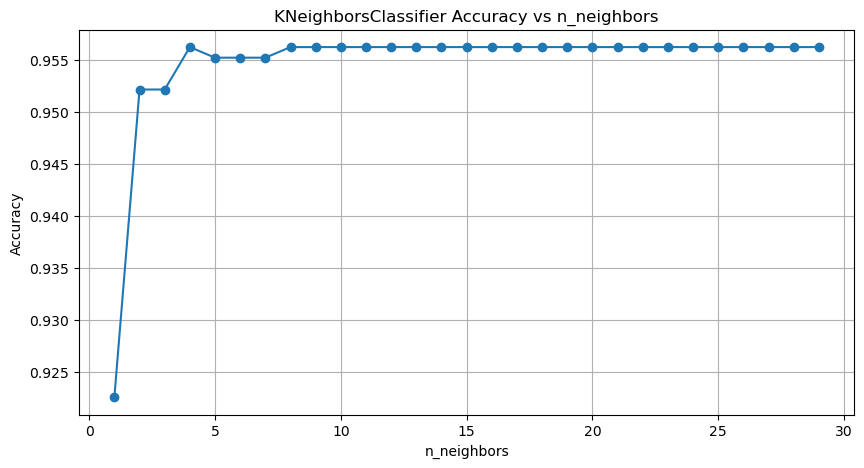

In [791]:
best_k, best_score, all_scores = tune_hyperparameter(
    model_class=KNeighborsClassifier,
    param_name='n_neighbors',
    param_values=range(1, 30),
    X_train=X_train_norm_knn,
    y_train=y_train_knn,
    X_test=X_test_norm_knn,
    y_test=y_test_knn
)

In [792]:
dfv1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4908 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           4908 non-null   float64
 1   hypertension                  4908 non-null   int64  
 2   heart_disease                 4908 non-null   int64  
 3   avg_glucose_level             4908 non-null   float64
 4   bmi                           4908 non-null   float64
 5   stroke                        4908 non-null   int64  
 6   gender_numeric                4908 non-null   int64  
 7   ever_married_numeric          4908 non-null   int64  
 8   work_type_private             4908 non-null   int32  
 9   work_type_self_employed       4908 non-null   int32  
 10  work_type_govt_job            4908 non-null   int32  
 11  work_type_children            4908 non-null   int32  
 12  work_type_never_worked        4908 non-null   int32  
 13  residenc

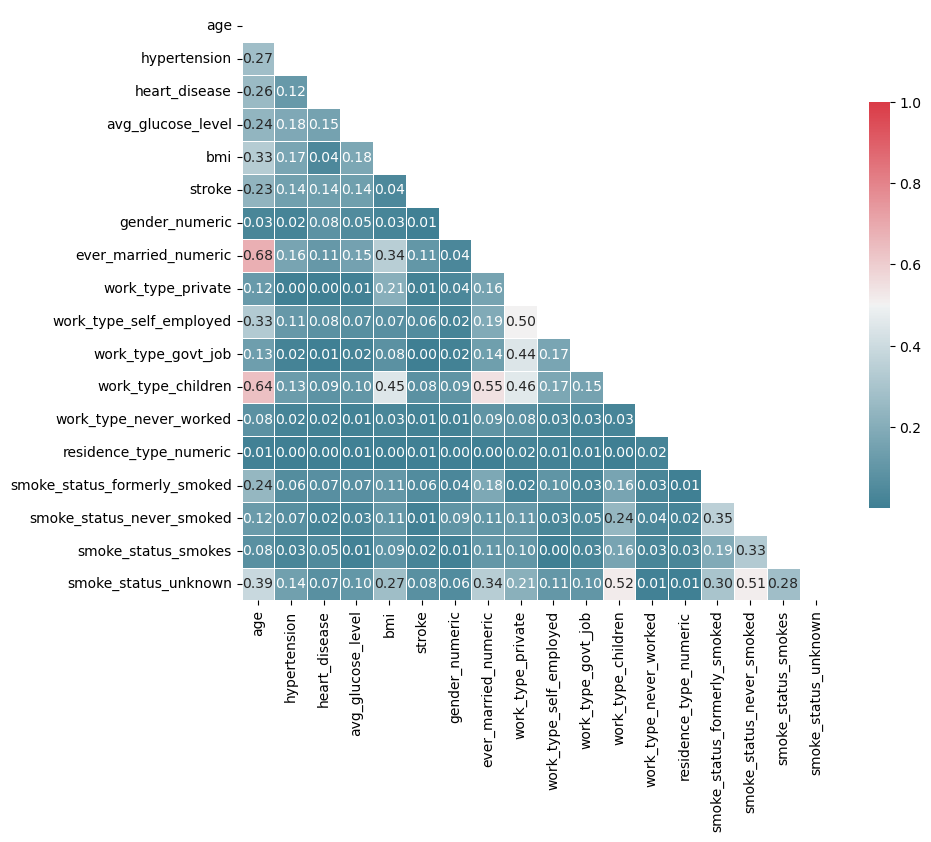

In [793]:
corr=np.abs(dfv1.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .5},
    annot=True,  # Show numbers
    fmt=".2f",  # Format numbers to 2 decimals
    annot_kws={"size": 10, "ha": 'center', "va": 'center'}  # Style annotations
)
plt.tight_layout()
plt.show()

In [794]:
def print_all_metrics(y_true, y_pred, y_prob=None, positive_label=1):
    """
    Print a full set of classification metrics:
      - accuracy
      - classification_report (precision, recall, f1, support)
      - confusion matrix, plus derived sensitivity/specificity
      - (optional) ROC AUC if you pass in y_prob for the positive class

    Parameters:
        y_true      – ground‐truth labels
        y_pred      – predicted labels
        y_prob      – predicted probability (or score) for the positive class; if None, skip ROC AUC
        positive_label – which label is “positive” (default 1)
    """

    # 1) Overall accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.3f}\n")

    # 2) Full classification report
    print("Classification report:\n")
    print(classification_report(y_true, y_pred, digits=3))

    # 3) Confusion matrix → derive sensitivity (recall) & specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, positive_label]).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    print("Confusion matrix (true_neg, false_pos, false_neg, true_pos):")
    print(f"    TN = {tn},  FP = {fp}")
    print(f"    FN = {fn},  TP = {tp}\n")
    print(f"Sensitivity (Recall₁) = {sensitivity:.3f}")
    print(f"Specificity (Recall₀) = {specificity:.3f}\n")

    # 4) Precision/Recall/F1 (for positive_label)
    p = precision_score(y_true, y_pred, pos_label=positive_label, zero_division=0)
    r = recall_score(y_true, y_pred, pos_label=positive_label, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=positive_label, zero_division=0)
    print(f"Precision (PPV)₁ = {p:.3f}")
    print(f"Recall (Sensitivity)₁ = {r:.3f}")
    print(f"F1-score₁       = {f1:.3f}\n")

    # 5) (Optional) ROC AUC for the positive class
    if y_prob is not None:
        try:
            auc = roc_auc_score(y_true, y_prob)
            print(f"ROC AUC (pos_label={positive_label}) = {auc:.3f}")
        except Exception:
            print("Could not compute ROC AUC (check y_prob).")


In [795]:
def grid_search_with_progress(estimator, param_grid, X, y, cv=5, scoring=None, verbose=0, n_jobs=None, chunk_size=1, **kwargs):
    """
    GridSearchCV with a tqdm progress bar that updates in chunks.

    Parameters:
        estimator: Scikit-learn estimator instance.
        param_grid: Dict specifying parameter grid.
        X, y: Feature matrix and target array.
        cv: Number of CV folds.
        scoring: Scoring metric or callable.
        verbose: Verbosity level passed to GridSearchCV.
        n_jobs: Number of parallel jobs.
        chunk_size: Number of parameter‐sets to evaluate before updating tqdm.
        kwargs: Additional kwargs for GridSearchCV.

    Returns:
        The fitted GridSearchCV object.
    """
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        verbose=verbose,
        n_jobs=n_jobs,
        **kwargs
    )

    total_combinations = len(list(ParameterGrid(param_grid)))
    print(f"Running Grid Search with {total_combinations} parameter combinations...")

    orig_run_search = grid_search._run_search  # backup the original method

    def new_run_search(evaluate_candidates):
        def patched_evaluate(candidates):
            candidates_list = list(candidates)  # convert to list for slicing
            for i in range(0, len(candidates_list), chunk_size):
                chunk = candidates_list[i : i + chunk_size]
                evaluate_candidates(chunk)
                pbar.update(len(chunk))
        return orig_run_search(patched_evaluate)

    grid_search._run_search = new_run_search

    with tqdm(total=total_combinations, desc="Grid Search Progress", unit="comb") as pbar:
        grid_search.fit(X, y)

    return grid_search


In [796]:
param_grid_knn = {
    'n_neighbors': list(range(1, 31)),               # Number of neighbors
    'weights': ['uniform', 'distance'],            # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm for computing nearest neighbors
    'leaf_size': [20, 30, 40],                     # Leaf size for BallTree/KDTree
    'p': [1, 2],                                   # Power parameter for Minkowski metric: 1=Manhattan, 2=Euclidean
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Distance metric
}

In [797]:
#grid_search_knn01 = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5)
#grid_search_knn01.fit(X_train_norm_knn, y_train_knn)

In [798]:
#joblib.dump(grid_search_knn01, 'gridsearch/knn01_gridsearch.pkl')

In [799]:
grid_knn01 = joblib.load('gridsearch/knn01_gridsearch.pkl')

In [800]:
grid_knn01.best_params_

{'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 11,
 'p': 1,
 'weights': 'uniform'}

In [801]:
model_knn01 = grid_knn01.best_estimator_

In [802]:
model_knn01.fit(X_train_norm_knn,y_train_knn)

KNeighborsClassifier(leaf_size=20, n_neighbors=11, p=1)

In [803]:
print(y_train_knn.value_counts(normalize=True))
print(y_train_knn.value_counts())

stroke
0    0.957718
1    0.042282
Name: proportion, dtype: float64
stroke
0    3760
1     166
Name: count, dtype: int64


In [804]:
y_pred = knn.predict(X_test_knn)

In [805]:
print(classification_report(y_test_knn, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       939
           1       0.00      0.00      0.00        43

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.91      0.96      0.93       982



c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### KNN Oversampling

In [806]:
dfv1

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_numeric,ever_married_numeric,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_numeric,smoke_status_formerly_smoked,smoke_status_never_smoked,smoke_status_smokes,smoke_status_unknown
0,67.0,0,1,228.69,36.6,1,1,1,1,0,0,0,0,1,1,0,0,0
2,80.0,0,1,105.92,32.5,1,1,1,1,0,0,0,0,0,0,1,0,0
3,49.0,0,0,171.23,34.4,1,0,1,1,0,0,0,0,1,0,0,1,0
4,79.0,1,0,174.12,24.0,1,0,1,0,1,0,0,0,0,0,1,0,0
5,81.0,0,0,186.21,29.0,1,1,1,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,13.0,0,0,103.08,18.6,0,0,0,0,0,0,1,0,0,0,0,0,1
5106,81.0,0,0,125.20,40.0,0,0,1,0,1,0,0,0,1,0,1,0,0
5107,35.0,0,0,82.99,30.6,0,0,1,0,1,0,0,0,0,0,1,0,0
5108,51.0,0,0,166.29,25.6,0,1,1,1,0,0,0,0,0,1,0,0,0


In [807]:
stroke = dfv1[dfv1["stroke"] == 1]
no_stroke = dfv1[dfv1["stroke"] == 0]

In [808]:
yes_stroke_oversampled = resample(no_stroke, 
                                    replace=True, 
                                    n_samples = len(stroke),
                                    random_state=0)

In [809]:
train_over = pd.concat([yes_stroke_oversampled, stroke])
train_over

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_numeric,ever_married_numeric,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_numeric,smoke_status_formerly_smoked,smoke_status_never_smoked,smoke_status_smokes,smoke_status_unknown
3085,73.0,0,1,72.42,27.6,0,1,1,1,0,0,0,0,0,0,1,0,0
2953,53.0,0,0,95.47,26.0,0,1,1,1,0,0,0,0,0,0,0,1,0
1965,5.0,0,0,109.40,20.0,0,0,0,0,0,0,1,0,0,0,0,0,1
3637,82.0,0,0,226.84,25.3,0,1,1,1,0,0,0,0,1,1,0,0,0
1312,3.0,0,0,97.60,25.8,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,68.0,1,1,247.51,40.5,1,0,1,1,0,0,0,0,1,1,0,0,0
244,57.0,0,0,84.96,36.7,1,1,1,1,0,0,0,0,0,0,0,0,1
245,14.0,0,0,57.93,30.9,1,0,0,0,0,0,1,0,0,0,0,0,1
246,75.0,0,0,78.80,29.3,1,0,1,0,1,0,0,0,0,1,0,0,0


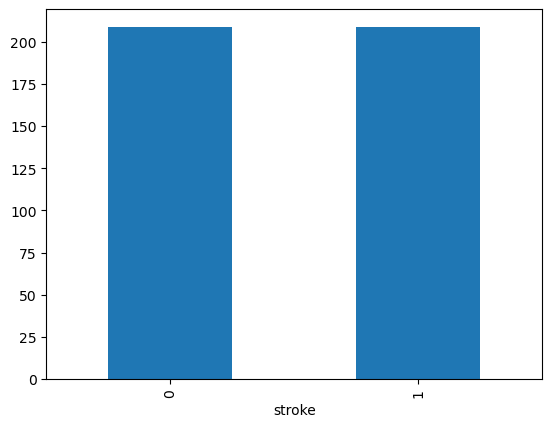

In [810]:
stroke = train_over["stroke"].value_counts()
stroke.plot(kind="bar")
plt.show()

In [811]:
X_train_over = train_over.drop(columns = ["stroke"])
y_train_over = train_over["stroke"]

In [812]:
best_params = {'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 2,
 'p': 1,
 'weights': 'uniform'}

# Option 1: instantiate from scratch using the best_params dict
model_knn02 = KNeighborsClassifier(**best_params)
model_knn02.fit(X_train_over, y_train_over)

KNeighborsClassifier(leaf_size=20, n_neighbors=2, p=1)

In [813]:
y_pred = knn.predict(X_test_knn)

In [814]:
print_all_metrics(
    y_true=y_test_knn,
    y_pred=y_pred,
    y_prob=None,       # or None if you don’t have probabilities
    positive_label=1         # make sure this matches your “stroke” label
)

Accuracy: 0.956

Classification report:

              precision    recall  f1-score   support

           0      0.956     1.000     0.978       939
           1      0.000     0.000     0.000        43

    accuracy                          0.956       982
   macro avg      0.478     0.500     0.489       982
weighted avg      0.914     0.956     0.935       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 939,  FP = 0
    FN = 43,  TP = 0

Sensitivity (Recall₁) = 0.000
Specificity (Recall₀) = 1.000

Precision (PPV)₁ = 0.000
Recall (Sensitivity)₁ = 0.000
F1-score₁       = 0.000



c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KNN SMOTE


In [815]:
sm = SMOTE(sampling_strategy=0.7)
X_res_knn, y_res_knn = sm.fit_resample(X_train_knn, y_train_knn)


model_knn01.fit(X_res_knn, y_res_knn)

KNeighborsClassifier(leaf_size=20, n_neighbors=11, p=1)

In [816]:
print_all_metrics(
    y_true=y_test_knn,
    y_pred=y_pred,
    y_prob=None,       # or None if you don’t have probabilities
    positive_label=1         # make sure this matches your “stroke” label
)

Accuracy: 0.956

Classification report:

              precision    recall  f1-score   support

           0      0.956     1.000     0.978       939
           1      0.000     0.000     0.000        43

    accuracy                          0.956       982
   macro avg      0.478     0.500     0.489       982
weighted avg      0.914     0.956     0.935       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 939,  FP = 0
    FN = 43,  TP = 0

Sensitivity (Recall₁) = 0.000
Specificity (Recall₀) = 1.000

Precision (PPV)₁ = 0.000
Recall (Sensitivity)₁ = 0.000
F1-score₁       = 0.000



c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [817]:
print(classification_report(y_test_knn, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       939
           1       0.00      0.00      0.00        43

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.91      0.96      0.93       982



c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [818]:
param_grid_knn = {
    'n_neighbors': list(range(1, 17)),               # Number of neighbors
    'weights': ['uniform'],            # Weight function used in prediction
    'algorithm': ['auto'],  # Algorithm for computing nearest neighbors
    'leaf_size': [20],                     # Leaf size for BallTree/KDTree
    'p': [1, 2],                                   # Power parameter for Minkowski metric: 1=Manhattan, 2=Euclidean
    'metric': ['minkowski']  # Distance metric
}

In [819]:
#grid_search_knn02 = grid_search_with_progress(model_knn01, param_grid_knn, X_res_knn, y_res_knn, cv=5, scoring= 'f1')
#print("Best parameters found:", grid_search_knn02.best_params_)


In [820]:
#grid_search_knn02.best_params_

In [821]:
best_params = {'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 2,
 'p': 1,
 'weights': 'uniform'}

# Option 1: instantiate from scratch using the best_params dict
model_knn02 = KNeighborsClassifier(**best_params)
model_knn02.fit(X_res_knn, y_res_knn)

KNeighborsClassifier(leaf_size=20, n_neighbors=2, p=1)

In [822]:
y_pred = model_knn02.predict(X_test_knn)

In [823]:
print(classification_report(y_test_knn, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       939
           1       0.12      0.35      0.18        43

    accuracy                           0.86       982
   macro avg       0.54      0.61      0.55       982
weighted avg       0.93      0.86      0.89       982



In [824]:
'''

| Metric       | Good Start | Great (ideal) |
| ------------ | ---------- | ------------- |
| Precision\_1 | ≥ 0.30     | ≥ 0.70        |
| Recall\_1    | ≥ 0.50     | ≥ 0.80        |
| F1-score\_1  | ≥ 0.40     | ≥ 0.70        |

'''

<>:1: SyntaxWarning: invalid escape sequence '\_'
<>:1: SyntaxWarning: invalid escape sequence '\_'
C:\Users\estif\AppData\Local\Temp\ipykernel_9304\3083410714.py:1: SyntaxWarning: invalid escape sequence '\_'
  '''


'\n\n| Metric       | Good Start | Great (ideal) |\n| ------------ | ---------- | ------------- |\n| Precision\\_1 | ≥ 0.30     | ≥ 0.70        |\n| Recall\\_1    | ≥ 0.50     | ≥ 0.80        |\n| F1-score\\_1  | ≥ 0.40     | ≥ 0.70        |\n\n'

In [825]:
#grid_search_knn02 = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5)
#grid_search_knn02.fit(X_res_knn, y_res_knn)


In [826]:
#joblib.dump(grid_search_knn02, 'gridsearch/knn02_gridsearch.pkl')

In [827]:
#grid_knn02 = joblib.load('gridsearch/knn02_gridsearch.pkl')

In [828]:
grid_knn02.best_params_


{'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 2,
 'p': 1,
 'weights': 'uniform'}

In [829]:
model_knn02 = grid_knn02.best_estimator_


In [830]:
model_knn02.fit(X_train_norm_knn,y_train_knn)

KNeighborsClassifier(leaf_size=20, n_neighbors=2, p=1)

In [831]:
print(classification_report(y_test_knn, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       939
           1       0.12      0.35      0.18        43

    accuracy                           0.86       982
   macro avg       0.54      0.61      0.55       982
weighted avg       0.93      0.86      0.89       982



#### Test Model No heart_disease column


In [832]:
dfv1_nohd = dfv1.copy()

In [833]:
dfv1_nohd.drop(columns=['heart_disease'], inplace=True)

In [834]:
# cheack value counts
# check imbalance. Imbalanced if  99% of one class and 1% of another


## Ordinal ML


#### Rows to Numeric - For Ordinal ML

In [835]:
dfv2 = df.copy()

In [836]:
dfv2.dropna(inplace=True)

In [837]:
dfv2.drop(columns=['id'], inplace=True)

In [838]:
dfv2['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [839]:
dfv2['gender_numeric'] = df['gender'].map({'Male': 1, 'Female': 0})

In [840]:
dfv2.drop(columns=['gender'], inplace=True)

In [841]:
dfv2['ever_married_numeric'] = df['ever_married'].map({'Yes': 1, 'No': 0})

In [842]:
dfv2.drop(columns=['ever_married'], inplace=True)

In [843]:
dfv2['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [844]:
dfv2['work_type_numeric'] = df['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})


In [845]:
dfv2.drop(columns=['work_type'], inplace=True)

In [846]:
dfv2['residence_type_numeric'] = df['residence_type'].map({'Rural': 0, 'Urban': 1})

In [847]:
dfv2.drop(columns=['residence_type'], inplace=True)

In [848]:
dfv2['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [849]:
dfv2['smoking_status_numeric'] = df['smoking_status'].map({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})

In [850]:
dfv2.drop(columns=['smoking_status'], inplace=True)

In [851]:
dfv2

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_numeric,ever_married_numeric,work_type_numeric,residence_type_numeric,smoking_status_numeric
0,67.0,0,1,228.69,36.6,1,1,1,0,1,0
2,80.0,0,1,105.92,32.5,1,1,1,0,0,1
3,49.0,0,0,171.23,34.4,1,0,1,0,1,2
4,79.0,1,0,174.12,24.0,1,0,1,1,0,1
5,81.0,0,0,186.21,29.0,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5104,13.0,0,0,103.08,18.6,0,0,0,3,0,3
5106,81.0,0,0,125.20,40.0,0,0,1,1,1,1
5107,35.0,0,0,82.99,30.6,0,0,1,1,0,1
5108,51.0,0,0,166.29,25.6,0,1,1,0,0,0


#### Random Forest

In [852]:
features = dfv2.drop(columns = ["stroke"])
target = dfv2["stroke"]

In [853]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(features, target, test_size = 0.20, random_state=0)

In [854]:
normalizer = StandardScaler()

normalizer.fit(X_train_rf)

StandardScaler()

In [855]:
X_train_norm_rf = normalizer.transform(X_train_rf)

X_test_norm_rf = normalizer.transform(X_test_rf)

In [856]:
X_train_rf_norm = pd.DataFrame(X_train_norm_rf, columns = X_train_rf.columns)
X_test_rf_norm = pd.DataFrame(X_test_norm_rf, columns = X_test_rf.columns)

In [857]:
forest = RandomForestClassifier(n_estimators=100,
                             max_depth=20)

In [858]:
forest.fit(X_train_norm_rf, y_train_rf)

RandomForestClassifier(max_depth=20)

In [859]:
print(classification_report(y_test_rf, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       939
           1       0.12      0.35      0.18        43

    accuracy                           0.86       982
   macro avg       0.54      0.61      0.55       982
weighted avg       0.93      0.86      0.89       982



#### Random Forest SMOTE

In [860]:
param_grid_rf = {
    # Number of trees in the forest
    'n_estimators': [100, 200],

    # Maximum depth of each tree (None = nodes expanded until all leaves are pure)
    'max_depth': [None, 10, 20, 30],

    # Minimum number of samples required to split an internal node
    'min_samples_split': [2, 5, 10],

    # Minimum number of samples required to be at a leaf node
    'min_samples_leaf': [1, 2, 4],

    # Number of features to consider when looking for the best split
    # - 'sqrt' is standard for random forest classification,
    # - 'log2' is another common choice,
    # - 0.5 means “50% of all features”
    'max_features': ['sqrt', 'log2', 0.5],

    # Handle class imbalance by weighting the positive class more heavily
    'class_weight': ['balanced', 'balanced_subsample'],

    # Whether to bootstrap samples when building trees
    'bootstrap': [True, False]
}


In [861]:
# 1) Build an imblearn Pipeline where SMOTE is applied first, then RF is trained
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 2) Prefix all RF parameters with 'rf__' and SMOTE params with 'smote__'
param_grid_rf_pipe = {
    'smote__sampling_strategy': [0.3, 0.7, 1.0],
    'rf__n_estimators':         [100, 200, 500],
    'rf__max_depth':            [None, 10, 20],
    'rf__min_samples_split':    [2, 5],
    'rf__min_samples_leaf':     [1, 2],
    'rf__max_features':         ['sqrt', 'log2'],
    'rf__class_weight':         ['balanced', 'balanced_subsample']
}

# 3) Run your grid‐search with progress on the original (un‐resampled) data
grid_search_rf = grid_search_with_progress(
    pipe,
    param_grid_rf_pipe,
    X_train_rf_norm,   # <-- the original X_train, not X_res_knn
    y_train_rf,        # <-- the original y_train, not y_res_knn
    cv=5,
    scoring='f1',
    n_jobs=-1
)


print_all_metrics(
    y_true=y_test_rf,
    y_pred=y_pred,
    y_prob=None,       # or None if you don’t have probabilities
    positive_label=1         # make sure this matches your “stroke” label
)

Running Grid Search with 432 parameter combinations...


Grid Search Progress: 100%|██████████| 432/432 [11:31<00:00,  1.60s/comb]

Accuracy: 0.857

Classification report:

              precision    recall  f1-score   support

           0      0.967     0.881     0.922       939
           1      0.118     0.349     0.176        43

    accuracy                          0.857       982
   macro avg      0.543     0.615     0.549       982
weighted avg      0.930     0.857     0.889       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 827,  FP = 112
    FN = 28,  TP = 15

Sensitivity (Recall₁) = 0.349
Specificity (Recall₀) = 0.881

Precision (PPV)₁ = 0.118
Recall (Sensitivity)₁ = 0.349
F1-score₁       = 0.176



In [ ]:
#grid_search_rf.best_params_
"""
{'rf__class_weight': 'balanced_subsample',
 'rf__max_depth': 10,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 100,
 'smote__sampling_strategy': 1.0}
 
"""

{'rf__class_weight': 'balanced_subsample',
 'rf__max_depth': 10,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 100,
 'smote__sampling_strategy': 1.0}

In [888]:
sm = SMOTE(sampling_strategy=0.8)
X_res_rf, y_res_rf = sm.fit_resample(X_train_rf, y_train_rf)


model_rf01 = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', min_samples_split=2, min_samples_leaf=1, class_weight='balanced_subsample')

model_rf01.fit(X_res_rf, y_res_rf)
y_pred = model_rf01.predict(X_test_rf)

print_all_metrics(
    y_true=y_test_rf,
    y_pred=y_pred,
    y_prob=None,       # or None if you don’t have probabilities
    positive_label=1         # make sure this matches your “stroke” label
)

Accuracy: 0.805

Classification report:

              precision    recall  f1-score   support

           0      0.973     0.819     0.890       939
           1      0.115     0.512     0.187        43

    accuracy                          0.805       982
   macro avg      0.544     0.665     0.538       982
weighted avg      0.936     0.805     0.859       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 769,  FP = 170
    FN = 21,  TP = 22

Sensitivity (Recall₁) = 0.512
Specificity (Recall₀) = 0.819

Precision (PPV)₁ = 0.115
Recall (Sensitivity)₁ = 0.512
F1-score₁       = 0.187



#### Decision Tree (Bagging)

In [862]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(features, target, test_size = 0.20, random_state=0)

In [863]:
normalizer = StandardScaler()

normalizer.fit(X_train_dt)

StandardScaler()

In [864]:
X_train_norm_dt = normalizer.transform(X_train_dt)

X_test_norm_dt = normalizer.transform(X_test_dt)

In [865]:
X_train_norm_dt = pd.DataFrame(X_train_norm_dt, columns = X_train_rf.columns)
X_test_norm_dt = pd.DataFrame(X_test_norm_dt, columns = X_test_rf.columns)

In [866]:
bagging_reg = BaggingClassifier(DecisionTreeClassifier(max_depth=20),
                               n_estimators=100,
                               max_samples = 1000)

In [867]:
bagging_reg.fit(X_train_norm_dt, y_train_dt)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                  max_samples=1000, n_estimators=100)

In [868]:
print(classification_report(y_test_dt, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       939
           1       0.12      0.35      0.18        43

    accuracy                           0.86       982
   macro avg       0.54      0.61      0.55       982
weighted avg       0.93      0.86      0.89       982

